# CRIC Autoplier Survival Analysis 

In [1]:
import os
import autoplier.model as ap
import autoplier.plot as plot

import pandas as pd
import numpy as np

#from functools import reduce

from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sksurv.nonparametric import kaplan_meier_estimator 

import matplotlib.pyplot as plt


#import csv
#import h5py
#import json
#import mygene
#from onto_lib import general_ontology_tools as got
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import precision_score, recall_score, average_precision_score
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import MultiLabelBinarizer
#

# Setup

In [2]:
# seed
seed = 3306059
 
# data path
datadir = os.path.join('data')

#results path
outdir = os.path.join('results')


# Download Data

In [3]:
# - - - - - - Download Data  - - - - - -
#get membership data
#membdf=pd.read_csv(os.path.join(datadir, 'membership.csv'), sep=',')
membdf=pd.read_csv(os.path.join(datadir, 'ion2pathway.csv'), sep=',')
#print(membdf.columns)

#get omics data
omdf=pd.read_csv(os.path.join(datadir, 'untargeted_annotatedions.csv'), sep=',')
#print(omdf.columns)

#get omics annotations
anndf=pd.read_csv(os.path.join(datadir, 'CRIC_annotation_1mD_neg.csv'), sep=',')

#get clinical data
#clindf=pd.read_csv(os.path.join(datadir, 'partitioning.csv'),index_col='record_id', sep=',')
clindf=pd.read_csv(os.path.join(datadir, 'preprocessing_results.csv'), sep=',')
#print(clindf.columns)


In [4]:
#get omics annotations
print(anndf.columns)
print(membdf.columns[0:10])
print(omdf.columns[0:10])
print(clindf.columns)

Index(['id', 'name', 'formula', 'mz', 'mod', 'score', 'rank', 'mzDelta', 'ion',
       'TIC correl', 'average int'],
      dtype='object')
Index(['Unnamed: 0', 'Cyclophosphamide.Action.Pathway',
       'Cyclophosphamide.Metabolism.Pathway', 'Ifosfamide.Action.Pathway',
       'Ifosfamide.Metabolism.Pathway', 'Ketone.Body.Metabolism',
       'Succinyl.CoA..3.ketoacid.CoA.transferase.deficiency',
       'Amino.Sugar.Metabolism', 'Aspartate.Metabolism', 'Canavan.Disease'],
      dtype='object')
Index(['patientid', 'visit', 'group', 'V1', 'V6', 'V11', 'V15', 'V18', 'V20',
       'V23'],
      dtype='object')
Index(['patientid', 'mu_egfr_rate', 'sigma_egfr_rate', 'acearb_v3y0',
       'african_ancestry_v3y0', 'age_integer_v3y0', 'albuminuria_v3y0',
       'apol1_risk_alleles_v3y0', 'caucasian_ancestry_v3y0',
       'chinese_japanese_ancestry_v3y0',
       ...
       'time_mi_p_cnsr_v3y0', 'time_pad_v3y0', 'time_pad_cnsr_v3y0',
       'ualbumin24h_v3y0', 'ucreatinine24h_v3y0', 'uprotein24h_v

# Sanity Check Data

In [5]:
clindf.head()

,patientid,mu_egfr_rate,sigma_egfr_rate,acearb_v3y0,african_ancestry_v3y0,age_integer_v3y0,albuminuria_v3y0,apol1_risk_alleles_v3y0,caucasian_ancestry_v3y0,chinese_japanese_ancestry_v3y0,...,time_mi_p_cnsr_v3y0,time_pad_v3y0,time_pad_cnsr_v3y0,ualbumin24h_v3y0,ucreatinine24h_v3y0,uprotein24h_v3y0,urine_albumin_v3y0,urine_creatinine_v3y0,urine_protein_mg_dl_v3y0,waist_v3y0
0,1010001,-0.068201,0.188699,1,6.6,70,1,0,88.4,5.0,...,10.906849,10.906849,10.906849,0.007304,1.041892,0.029217,2.5,35.66,1,100.5
1,1010007,-0.105450,0.199372,1,82.2,69,3,1,16.6,1.3,...,0.383562,4.875470,4.875470,0.414370,1.117583,0.573639,122.8,33.12,17,83.0
2,1010008,-0.012396,0.218453,1,80.7,68,2,1,18.1,1.1,...,5.605479,5.605479,5.605479,0.043890,2.045274,0.079800,16.5,76.89,3,108.0
3,1010013,-0.054251,0.244502,1,84.3,61,3,2,13.7,2.0,...,7.202740,10.753425,7.202740,0.381342,1.513498,0.593529,205.6,81.60,32,98.0
4,1010015,-0.290542,0.361062,1,10.4,49,4,0,88.5,1.1,...,4.949203,10.778082,4.949203,7.817500,2.268665,8.374000,2950.0,85.61,316,109.5


 # Formatting

In [6]:
#make patientid an integer in clindf an make it the index
clindf['patientid'] = clindf['patientid'].astype(int)
clindf = clindf.set_index('patientid')

#remove the 'V' prefix in the omic column names
oldcols = omdf.columns[3:]
newcols = omdf.columns[3:].str[1:]
coldict = {oldcols[i]: newcols[i] for i in range(len(oldcols))}
omdf.rename(columns=coldict, inplace=True)

#name ion column in membership data
membdf.rename(columns={'Unnamed: 0': 'ion'}, inplace=True)

#convert the ion column to a string in membership data
membdf['ion'] = membdf['ion'].astype(str)

# Partition Data

In [7]:
#  - - - - - - Partition Data  - - - - - -
#partition observations by group
trainrecs = omdf.index[omdf["group"]<4].to_series()
validrecs = omdf.index[omdf["group"]==4].to_series()
allrecs = pd.concat([trainrecs,validrecs])

#get Xtrain and Xvalid
Xtrain = omdf.loc[trainrecs, : ].set_index('patientid')
Xvalid = omdf.loc[validrecs, : ].set_index('patientid')

#drop uncessary columns
Xtrain.drop(columns=["visit", "group"], inplace=True)
Xvalid.drop(columns=["visit", "group"], inplace=True)
#print(Xtrain.columns)
#print(Xvalid.columns)


In [8]:
# - - - - - -  QC  - - - - - -
#remove inf
Xtrain = Xtrain.replace( np.inf , np.nan )
Xvalid = Xvalid.replace( np.inf , np.nan )

#replace NA with half the minimum
Xtrain = Xtrain.replace(np.nan, np.min(Xtrain, axis=0)/2)
Xvalid = Xvalid.replace(np.nan, np.min(Xvalid, axis=0)/2)

#assert all values are complete and positive
assert(np.all(~Xtrain.isnull()))
assert(np.all(Xtrain>0))


In [9]:
# demonstrate partitions cannot be predicted
#(todo)

In [10]:
print(omdf)

      patientid  visit  group          1          6         11         15  \
0       1010001      7      0  11.275077  13.894439  11.004010  14.563137   
1       1010001      3      0  12.573245  14.284029  11.912665  15.802037   
2       1010001      9      0  11.975597  14.680360  11.822690  15.816009   
3       1010001      9      0  12.044189  14.721740  12.013602  15.702524   
4       1010001      7      0  11.638119  13.806550  10.859690  14.509961   
...         ...    ...    ...        ...        ...        ...        ...   
4739    7027227      3      3  11.140060  13.752690  11.237150  15.408730   
4740    7027227      7      3  10.894590  12.765000  10.513830  14.509280   
4741    7027227      7      3  10.731150  12.553460  10.384030  14.558780   
4742    7027227      9      3  11.029980  13.243640  11.253970  14.826750   
4743    7027227      9      3  10.891480  13.027560  10.600940  14.781620   

             18         20         23  ...      15278      15280      15295

# Omics to pathway transformation

In [11]:
#assert all omics are in the membership data
missingomics =  Xtrain.columns[~Xtrain.columns.isin(membdf["ion"])]
if len(missingomics)>0:
    # WARNING: missing omics
    print("the following omics were not found in the membership data.")
    print(missingomics)
assert(len(missingomics)==0)

In [12]:
#get the standardized omics labels for the columns in X
bigomega = Xtrain.columns
#print(bigomega)

In [13]:
#order membership data by the omics order (columns of X)
Cmat = membdf.set_index("ion")
Cmat = Cmat.reindex(bigomega)
#print(Cmat)

In [14]:
#transpose membership matrix so pathways are in rows and omics are in columns
Cmat = Cmat.T

#get unique pathways
_, uidx, invidx = np.unique(Cmat, return_index=True, return_inverse=True, axis=0)
Cmat = Cmat.iloc[uidx]

#print(Cmat.head())
#print(Cmat.shape)
#get the known pathway and metbolite classes (Pi) order
bigpi = Cmat.columns

In [15]:
print(Cmat)

                                                    1  6  11  15  18  20  23  \
Phosphatidylcholine.Biosynthesis.PC.18.4.6Z.9Z....  0  0   0   0   0   0   0   
Phosphatidylcholine.Biosynthesis.PC.16.1.9Z..24...  0  0   0   0   0   0   0   
Phosphatidylcholine.Biosynthesis.PC.16.0.22.6.4...  0  0   0   0   0   0   0   
Capecitabine.Action.Pathway                         0  0   0   0   0   0   0   
Phosphatidylcholine.Biosynthesis.PC.14.0.22.5.4...  0  0   0   0   0   0   0   
...                                                .. ..  ..  ..  ..  ..  ..   
Fatty.Acid.Biosynthesis                             0  0   0   1   0   1   0   
Amino.Sugar.Metabolism                              0  0   0   1   0   1   0   
Leigh.Syndrome                                      0  0   0   1   0   1   0   
Ketone.Body.Metabolism                              0  1   0   0   0   0   0   
Cyclophosphamide.Action.Pathway                     1  0   0   0   0   0   0   

                                       

In [16]:
#--- dump formatted xtrain, xvalid, and cmat
Xtrain.to_csv(os.path.join(outdir, 'Xtrain.csv'))
Xvalid.to_csv(os.path.join(outdir, 'Xvalid.csv'))
Cmat.to_csv(os.path.join(outdir, 'Cmat.csv'))
clindf.to_csv(os.path.join(outdir, 'clinical.csv'), index=True)

# Setup Autoplier

In [17]:
#fixed hyperparameters
maxepoch = 2000
patience = 100
batch_size= None
valfrac = .3
learning_rate = .002
decay_rate= learning_rate/maxepoch
regval = 1E-7

In [18]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=patience, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

# Estimate number of latent variables

In [19]:
#  - - - - - - Init guess data compressibility  - - - - - -
# Full dof PCA for all data
pca = PCA(random_state = seed) #do not define number of PCs

#transform omics into pathway representation
Xtilde = np.dot(Xtrain, Cmat.T.to_numpy())

#fit pca on the training data
X_pca = pca.fit_transform(Xtilde)

# compute total variation explained
totvar = sum(pca.explained_variance_)
cum_var = np.cumsum(pca.explained_variance_)/totvar

#show variation explained (diagnostic only)
#nPC = 50
#print(cum_var[0:nPC])

#choose nLV = whichever is less: 2 times the number of PCs that explain 99% of variation, or 90% of pathways
nLV = np.min([len(np.where(cum_var<=.99)[0])*2, len(Cmat.index)*.90])
print(nLV)

42.0


# Estimate regularization constant

In [20]:
# --- init guess target sparsity based on size LV matrix (bigPI x nLV) ---
# say the LVs are non trivial with 10 major Pathway components in each 
# 1- (nLV * 10) / (nLV * npathways)
target_sparsity = 1 - (10/len(bigpi))
print(len(bigpi))
print(target_sparsity)

2805
0.9964349376114082


In [21]:
#Optimize regularizaton for given target sparsity
def optimize_l1(target_sparsity, delta, start_l1, X, pathways, n_components):
 
    #initialize values
    ap.set_seed_(seed)
    nrep = 5
    sparsity = np.zeros(nrep)
    mu = np.mean(sparsity)
    #sparsity = 0
    tuning_l1 = start_l1
    step = 10
    closest = 1
    closest_l1 = tuning_l1
    #while abs(sparsity - target_sparsity) > delta:
    while abs(mu - target_sparsity) > delta:

        #reinit sparsity buffer
        sparisity = None
        
        #train model replicates
        for imodel in range(nrep):

            #create model
            mod = ap.autoPLIER(n_components, regval=tuning_l1, learning_rate=learning_rate)

            #set normalizer
            ap.scaler = Normalizer(norm='l1', copy=True)

            #train model
            mod.fit(X, pathways, callbacks, batch_size=batch_size,
                    maxepoch=maxepoch, verbose=0, valfrac=valfrac)

            #compute sparsity :number of elements greater than epsilon(1E-4)
            sparsity[imodel] = ap.sparsity_epsilon(mod.components_decomposition_, 10 ** -4)

        print(sparsity)
        #print mean, std and CV of sparsity
        mu = np.mean(sparsity)
        sigma = np.std(sparsity)
        print(mu, sigma, sigma/mu)
            
        #compute distance to target sparsity
        #diff = sparsity - target_sparsity
        diff = mu - target_sparsity
        
        #update closest sparsity
        if abs(diff) < closest and diff < 0:
            closest = abs(diff)
            closest_l1 = tuning_l1
            #check if diff is still to big else main loop should end
            if abs(diff) > delta:
                tuning_l1 = tuning_l1 * step

        else:

            if diff > 0:
                step = step / 2
                tuning_l1 = closest_l1 * step
            else:
                tuning_l1 = closest_l1 / step
                step = step / 2
                tuning_l1 = tuning_l1 * step
                
        #print(sparsity, diff, closest_l1)
        print(diff, closest_l1)
        
    return closest_l1

In [22]:
# set regularization value to aim for target sparsity
#regval = optimize_l1(target_sparsity=target_sparsity, delta=.005, start_l1=1E-5, X=Xtrain, pathways=Cmat, n_components=nLV)

In [23]:

print(regval)

1e-07


# Training

In [25]:
# unsupervised training scheme
def train_autoplier(X, pathways, n_LVs, regval):
    #set seed
    ap.set_seed_(seed)

    #create model
    model = ap.autoPLIER(n_LVs, regval = regval, learning_rate= learning_rate)
    #model = ap.autoPLIER(n_LVs, regval = 0, learning_rate= learning_rate)
    
    #set normalizer
    ap.scaler = Normalizer(norm='l1', copy=True)
    
    #fit model
    model.fit(X, pathways, callbacks, batch_size=batch_size, maxepoch=maxepoch, verbose=0, valfrac=valfrac)
    
    # compute latent variables
    Z = model.transform(X, pathways)
    
    # diagnostic - print sparsity
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    #return latent variables and trained model
    return Z, model

In [26]:
Z, model = train_autoplier(Xtrain, Cmat, nLV, regval)
print(Z)

2022-02-08 16:23:39.560925: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.9738955823293173
                 0         1         2         3         4         5   \
patientid                                                               
1010001    0.514136  0.000000  0.000000  0.000000  0.052697  0.941248   
1010001    1.357012  0.723666  0.668570  1.259206  0.224735  1.353223   
1010001    1.547833  0.958326  0.622721  1.254555  0.317979  1.750971   
1010001    1.524645  1.035046  0.671253  1.299252  0.323587  1.698858   
1010001    0.472815  0.000000  0.045076  0.000000  0.061217  0.919235   
...             ...       ...       ...       ...       ...       ...   
7027227    0.592297  0.435250  0.468465  1.251946  0.263684  0.800595   
7027227    0.449754  0.553721  0.000000  0.169877  0.000000  0.000000   
7027227    0.420897  0.807521  0.000000  0.183628  0.000000  0.000000   
7027227    0.974135  0.243907  0.140205  1.217528  0.195634  0.369524   
7027227    0.980465  0.235317  0.077055  1.012846  0.186846  0.308554   

                 6         7   

# Classifier

In [30]:
# select covariates
covariates = ['mu_egfr_rate', 'sigma_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
              'urine_albumin_v3y0', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
#print(clindf[covariates])
#select normo albuminuria patients
clinred = clindf.loc[clindf['albuminuria_v3y0']==1, covariates]

#log transform urine_albumin
clinred['urine_albumin_v3y0'] = np.log2(clinred['urine_albumin_v3y0']+1)

#print(clinred)


In [27]:
# define classifier
def classify(mod, Xtrain, Cmat, clin, clinadj=True):
    
    #outcome = 'mu_egfr_rate'
    
    #select patients by record_id in the X data
    y = clin[clin.index.isin(Xtrain.index)]

    ##drop pats with missing outcome
    #y = y.loc[~y['mu_egfr_rate'].isna()]
    
    #select Xtrain patients with outcomes
    X = Xtrain[Xtrain.index.isin(y.index)]

    #drop duplicate patientids
    X = X[~X.index.duplicated(keep='first')]
 
    #get outcome for every patient in X
    y = clindf.loc[X.index]

    #confirm equal number of samples
    assert(len(X.index)==len(y.index))
    
    #encode categorical rapid progressor outcome
    le = LabelEncoder()
    le.fit([True, False])
    yt = le.transform(y['mu_egfr_rate'] > y['mu_egfr_rate'].mean())
    #yt = le.transform(y['mu_egfr_rate'] > y['mu_egfr_rate'].quantile(2/3))

    ##encode categorical volital progressor outcome
    #le = LabelEncoder()
    #le.fit([True, False])
    #yt = le.transform(y['sigma_egfr_rate'] > y['sigma_egfr_rate'].mean())

    #encode categorical sex clinical variable
    le = LabelEncoder()
    le.fit(y['sex_v3y0'].unique())
    y['sex_v3y0'] = le.transform(y['sex_v3y0'])

    #encode categorical race clinical variable
    le = LabelEncoder()
    le.fit(y['race_ethnicity_cat2_v3y0'].unique())
    y['race_ethnicity_cat2_v3y0'] = le.transform(y['race_ethnicity_cat2_v3y0'])
    
    #drop book keeping variables and outcomes
    y.drop(columns=['mu_egfr_rate', 'sigma_egfr_rate'], inplace=True)
   
    #transform Xtrain data into latent representation
    Z = mod.transform(X, Cmat)

    #add clinical variables
    if clinadj:
        Z.merge(y, on='patientid')
     
    #Latent variable PCA represenation
    pca = PCA(n_components=2, random_state = seed)
    Z_pca = pca.fit_transform(Z)
    
    #visualize case/ctrl patients projected on first 2 prinicpal components
    fig = plt.figure()
    ax = fig.add_subplot()
    scatter = ax.scatter(Z_pca[:,0], Z_pca[:,1], c = yt)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="fast progressors")
    ax.add_artist(legend1)

    ax.legend()
    plt.show()
    
    PARAMETERS = {
        'C': [
        0.001,
        0.002,
        0.005,
        0.01,
        0.02,
        0.05,
        0.1,
        0.2,
        0.5,
        1.0,
        2.0,
        5.0,
        10.0,
        20.0,
        50.0,    
        100.0,
        200.0,
        500.0,    
        1000.0,
        ]
    }
    MAX_ITER = 200000

    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear',
                                  #class_weight='balanced',
                                  random_state=seed)

    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
    clf = GridSearchCV(lr_model, PARAMETERS, scoring='roc_auc')
    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='neg_log_loss')
    clf.fit(Z, yt)

    best_params = max(
        zip(
            clf.cv_results_['param_C'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_C = best_params[0]
    print('Mean test scores:')
    print(clf.cv_results_['mean_test_score'])
    print("Best C chosen: ", best_C)
    
    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear', 
                                  #class_weight='balanced',
                                  random_state=seed,
                                  C=best_C)
    lr_model.fit(Z, yt)
    coeffs = lr_model.coef_
    coeffs = coeffs.squeeze()
    print(coeffs)
    
    largest = coeffs.argsort()[-5:]
    smallest = coeffs.argsort()[:5]
    
    largest_vals = [coeffs[x] for x in largest]
    smallest_vals = [coeffs[x] for x in smallest]
    
    print("LVs associated with classification of rapid progressors :" )
    print(largest)
    print(largest_vals)
    for lv in largest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')
        plt.show()
    
    print("LVs associated with classification of slow progressors :" )
    print(smallest)
    print(smallest_vals)
    for lv in smallest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


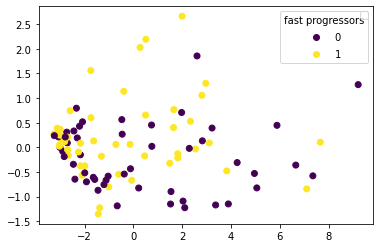

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/m

Mean test scores:
[0.5        0.5        0.5        0.5        0.5        0.5
 0.484      0.56611111 0.59855556 0.62022222 0.56022222 0.58822222
 0.60488889 0.63333333 0.65266667 0.64444444 0.618      0.60066667
 0.594     ]
Best C chosen:  50.0
[ 4.96271413e-01  9.29256139e+00 -5.64527262e+00  1.75924641e+00
 -1.64097717e+00  5.53110828e+00 -6.33760097e+00 -2.14171745e+01
 -2.95205696e+00 -8.38720233e+00  2.89039886e+00  1.56570793e+00
 -9.09511033e+00 -1.79337148e+01  1.08636028e+01 -2.80082712e+00
  3.27066884e+01  1.76950143e+01 -2.12022575e-01 -1.15403997e+01
 -3.64722806e-05  1.18911246e+01 -4.69395840e+00 -8.62071447e-01
  0.00000000e+00  3.28008057e+00 -4.80984064e+00  4.71047282e+00
 -2.58725229e+00 -9.45029075e+00  6.43783765e-01 -1.10821211e+00
  0.00000000e+00  1.19313330e+01  4.82512478e-01  3.42487434e+00
  9.19417523e-01  2.47344345e+00 -5.86338127e+00 -4.23765351e+00
 -5.69999517e+00  5.12525700e+00]
LVs associated with classification of rapid progressors :
[14 21 33 17

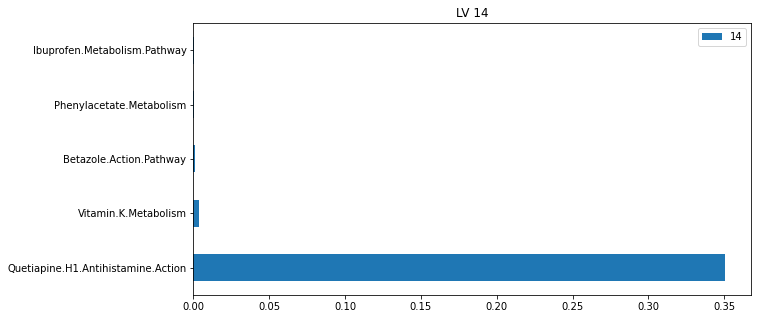

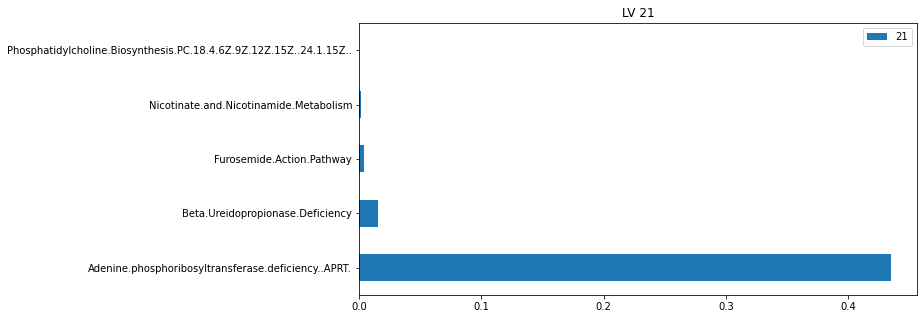

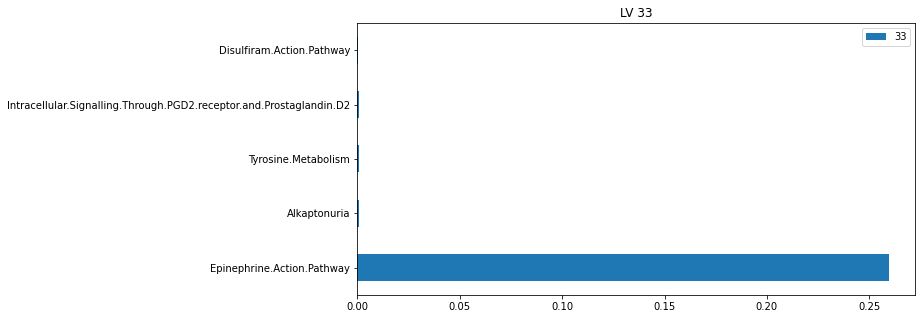

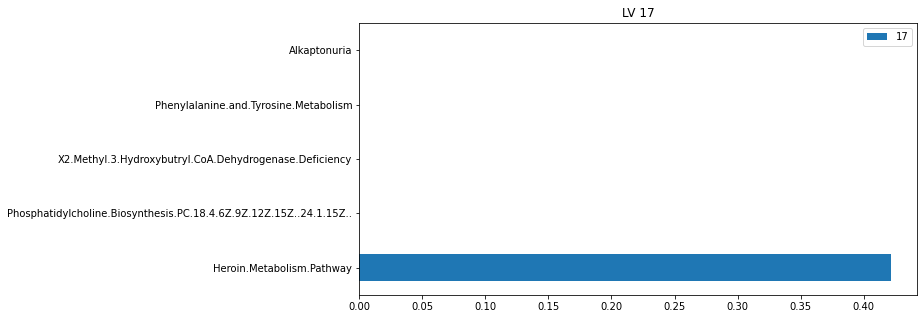

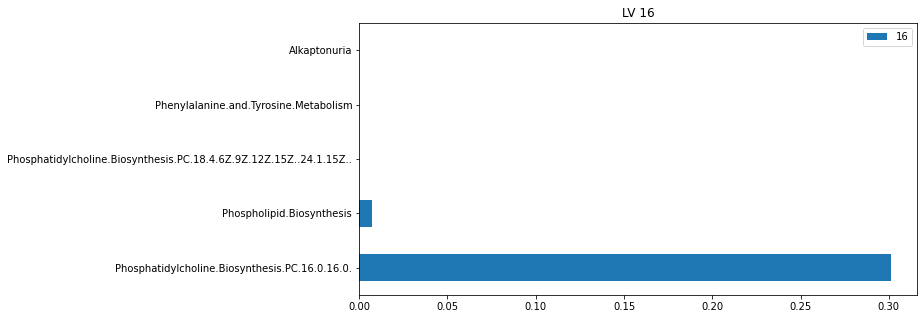

LVs associated with classification of slow progressors :
[ 7 13 19 29 12]
[-21.417174454532084, -17.933714832867782, -11.540399718388224, -9.450290749849465, -9.095110332285842]


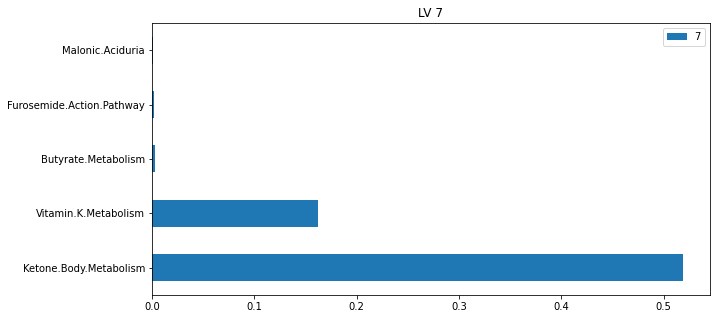

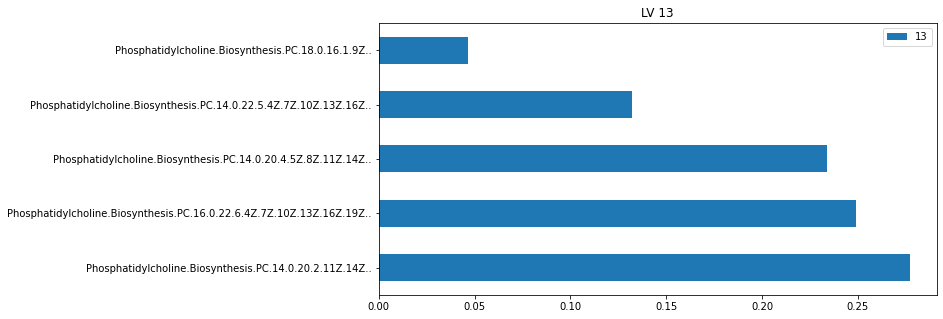

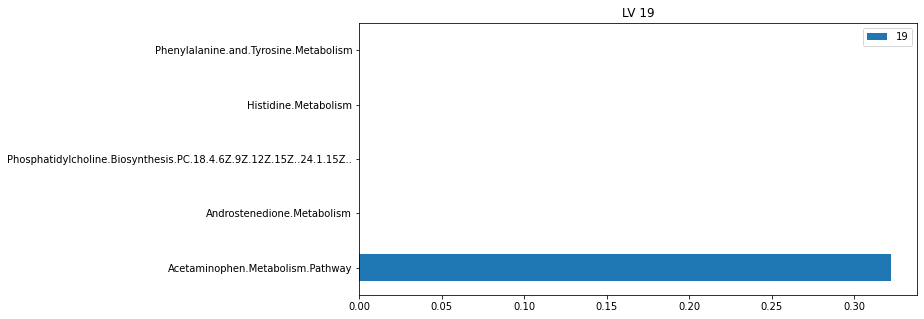

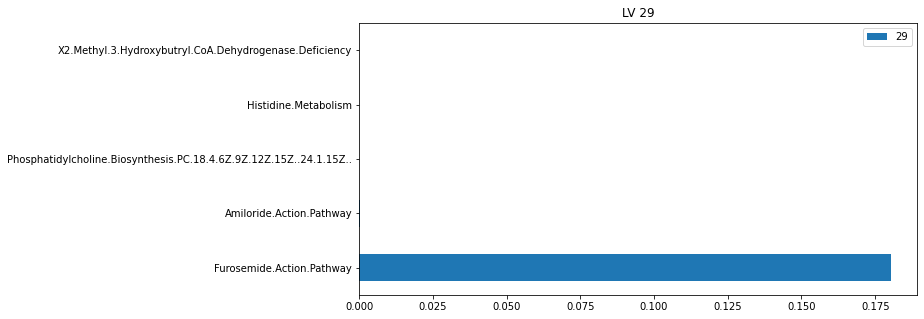

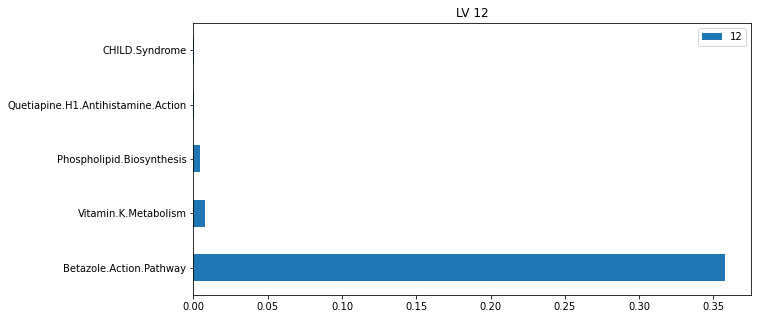

In [29]:
classify(model, Xtrain, Cmat, clinred)

# Survival Analysis

In [221]:
#print(np.array(clindf.columns))

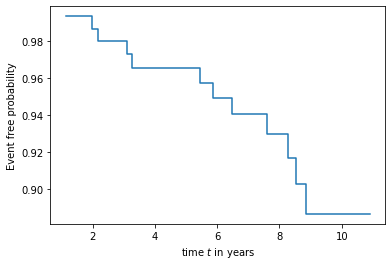

In [232]:
# define events
events = clindf['sa_allc_cric_renal3_v3y0']==1
exit_times = clindf['sa_allc_cric_time_renal3_v3y0']

#use only selected patients in clinred
events = events[events.index.isin(clinred.index)]
exit_times = exit_times[exit_times.index.isin(clinred.index)]

# Kaplan Meier Curve
time, survival_prob = kaplan_meier_estimator(events, exit_times)
plt.step(time, survival_prob, where="post")
plt.ylabel("Event free probability")
plt.xlabel("time $t$ in years")
plt.show()

In [233]:
#from sksurv.metrics import concordance_index_censored
#concordance_index_censored(events, exit_times, survival_prob, tied_tol=1e-08)

## Is there any difference in event probability between groups with high or low APRT pathway?

In [234]:
APRT_LV = 21
pathwaydict = model.get_top_pathways([APRT_LV], n_pathways=1)
df = pd.DataFrame(pathwaydict).fillna(0)

#print(df)
#print(df.index.values)

#assert we found where APRT pathway is 
assert(df.index.values[0]=='Adenine.phosphoribosyltransferase.deficiency..APRT.')

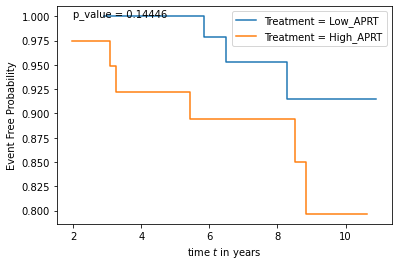

In [236]:
# partition treatment groups based on APART_LV
cutoff =  Z.iloc[:, APRT_LV].mean()
treatment_groups = pd.DataFrame()
treatment_groups['High_APRT'] = Z[APRT_LV] >= cutoff
treatment_groups['Low_APRT'] = Z.iloc[:, APRT_LV] < cutoff

#select patients by record_id in the events data
treatment_groups = treatment_groups[treatment_groups.index.isin(events.index)]
#drop duplicate patientids
treatment_groups = treatment_groups[~treatment_groups.index.duplicated(keep='first')]
#get outcome for every patient in treatment_groups
events = events.loc[treatment_groups.index]
exit_times = exit_times.loc[treatment_groups.index]
#confirm equal number of samples
assert(len(events.index)==len(treatment_groups.index))

#Zip events and exit times into a list of tuples
aux = list(zip(events, exit_times))
# Structured array
data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

# group indicator
group_indicator = pd.DataFrame(index=events.index)
group_indicator['group'] = 'High_APRT'
group_indicator.loc[treatment_groups['Low_APRT'],'group'] = 'Low_APRT'

# compare survival curves
chisq, pvalue, stats, covar = compare_survival(data_y, np.array(list(group_indicator['group'])), return_stats=True)
#print(chisq)
#print(pvalue)
#print(covar)

#compare High and Low APRT groups
for group in list(group_indicator['group'].unique()):
    mask = np.array(group_indicator==group).squeeze()
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        events[mask],
        exit_times[mask])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % group)

plt.ylabel("Event Free Probability")
plt.xlabel("time $t$ in years")
plt.legend(loc="best")
plt.annotate("p_value = "+str(round(pvalue, 5)), (2,1))
plt.show()

K-sample log-rank hypothesis test of identical survival functions.

Compares the pooled hazard rate with each group-specific hazard rate. The alternative hypothesis is that the hazard rate of at least one group differs from the others at some time.

Fleming, T. R. and Harrington, D. P. A Class of Hypothesis Tests for One and Two Samples of Censored Survival Data. Communications In Statistics 10 (1981): 763-794.

In [237]:
stats

,counts,observed,expected,statistic
group,,,,
High_APRT,39,6,3.838647,2.161353
Low_APRT,59,3,5.161353,-2.161353


In [280]:
#select patients in covariate data that have assigned group indication
data_x = clinred[clinred.index.isin(group_indicator.index)] 

#merge APRT_LV predictor and clinical covariates
data_x = data_x.join(group_indicator)

#drop book keeping variables and outcomes
#data_x.drop(columns=['mu_egfr_rate', 'sigma_egfr_rate'], inplace=True)

#encode binary sex clinical variable
data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
#le = LabelEncoder()
#le.fit(data_x['sex_v3y0'].unique())
#data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

#encode categorical race clinical variable
data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
#le = OneHotEncoder()#LabelEncoder()
#le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
#data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

#encode binary APART_LV group variable
data_x['group'] = data_x['group'].astype('category')
le = LabelEncoder()
le.fit(data_x['group'].unique())
data_x['group'] = le.transform(data_x['group'])
 
#encode categorical values
from sksurv.preprocessing import OneHotEncoder
data_x = OneHotEncoder().fit_transform(data_x)
    
    
#Zip events and exit times into a list of tuples
aux = list(zip(events, exit_times))
# Structured array
data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

#display(data_x)

In [281]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#init and train proportional hazard model
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

# show coeffiecients, where each value corresponds to the log hazard ratio.
lhr = pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"])
display(lhr.join(pd.DataFrame(np.exp(estimator.coef_), index=data_x.columns, columns=["hazard ratio"])))
#display(pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"]))
#display(pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"]))

#get C-statistic
print("Concordance statistic: " + str(estimator.score(data_x, data_y)))

,log hazard ratio,hazard ratio
age_integer_v3y0,0.032535,1.033070e+00
sex_v3y0=2,-2.184815,1.124985e-01
race_ethnicity_cat2_v3y0=2,-0.951800,3.860457e-01
race_ethnicity_cat2_v3y0=4,-17.988447,1.540695e-08
map_v3y0,0.042619,1.043540e+00
hemoglobin_a1c_v3y0,1.464343,4.324699e+00
waist_v3y0,0.047045,1.048169e+00
urine_albumin_v3y0,-0.719649,4.869229e-01
egfr_cric_v3y0,-0.213088,8.080854e-01
group,-2.001119,1.351839e-01


Concordance statistic: 0.9225908372827805


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


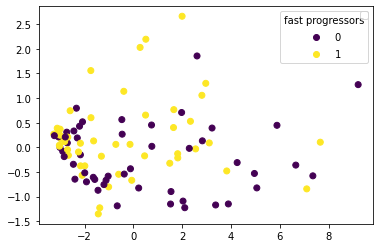

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/m

Mean test scores:
[0.5        0.5        0.5        0.5        0.5        0.5
 0.484      0.56611111 0.59855556 0.62022222 0.56022222 0.58822222
 0.60488889 0.63333333 0.65266667 0.64444444 0.618      0.60066667
 0.594     ]
Best C chosen:  50.0
[ 4.96271413e-01  9.29256139e+00 -5.64527262e+00  1.75924641e+00
 -1.64097717e+00  5.53110828e+00 -6.33760097e+00 -2.14171745e+01
 -2.95205696e+00 -8.38720233e+00  2.89039886e+00  1.56570793e+00
 -9.09511033e+00 -1.79337148e+01  1.08636028e+01 -2.80082712e+00
  3.27066884e+01  1.76950143e+01 -2.12022575e-01 -1.15403997e+01
 -3.64722806e-05  1.18911246e+01 -4.69395840e+00 -8.62071447e-01
  0.00000000e+00  3.28008057e+00 -4.80984064e+00  4.71047282e+00
 -2.58725229e+00 -9.45029075e+00  6.43783765e-01 -1.10821211e+00
  0.00000000e+00  1.19313330e+01  4.82512478e-01  3.42487434e+00
  9.19417523e-01  2.47344345e+00 -5.86338127e+00 -4.23765351e+00
 -5.69999517e+00  5.12525700e+00]
LVs associated with classification of rapid progressors :
[14 21 33 17

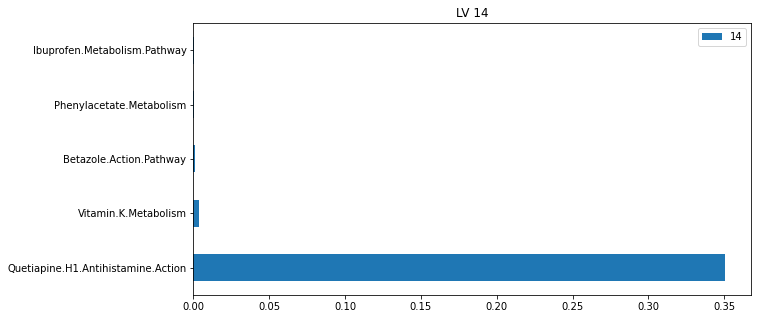

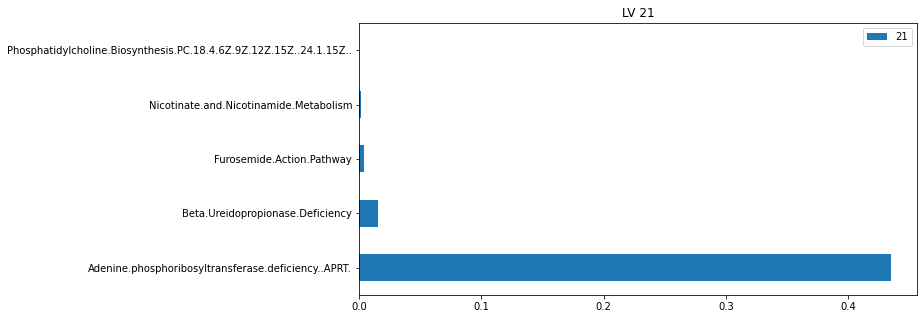

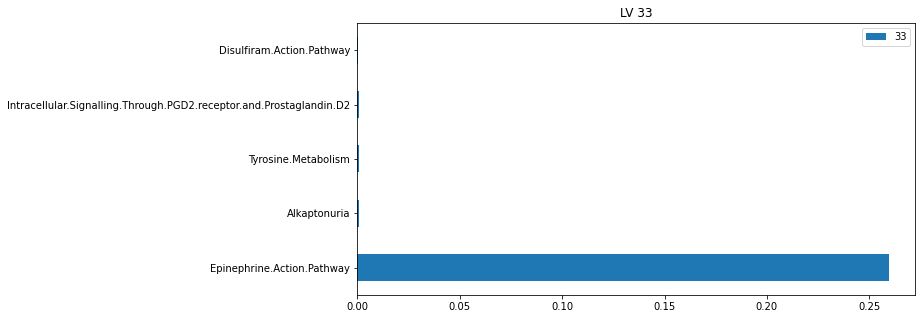

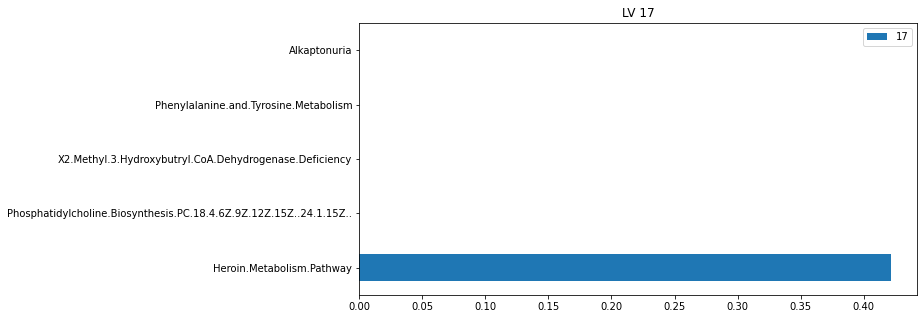

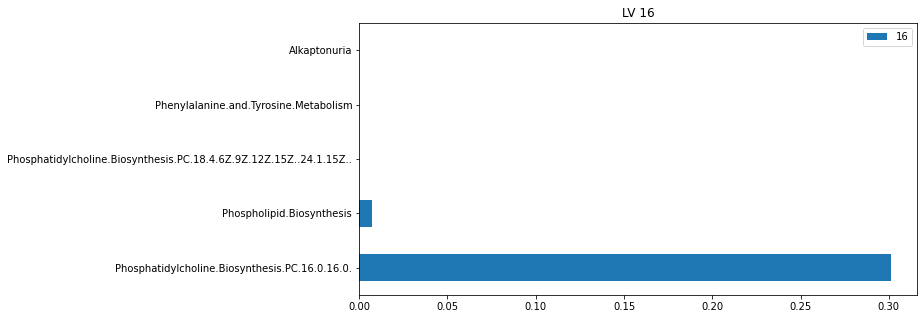

LVs associated with classification of slow progressors :
[ 7 13 19 29 12]
[-21.417174454532084, -17.933714832867782, -11.540399718388224, -9.450290749849465, -9.095110332285842]


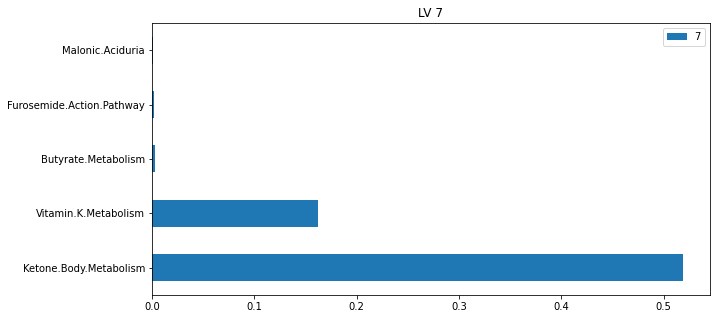

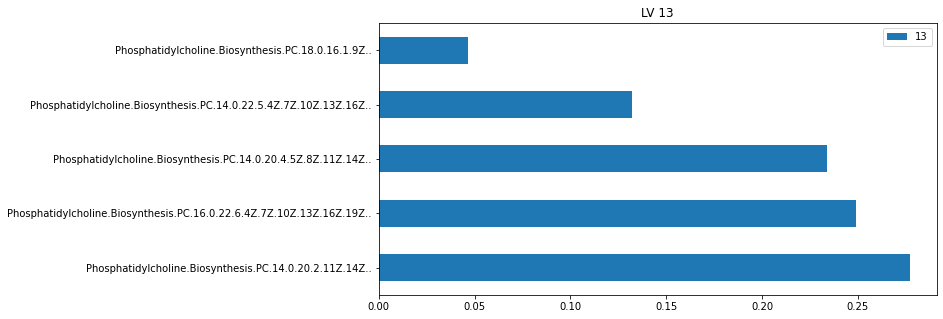

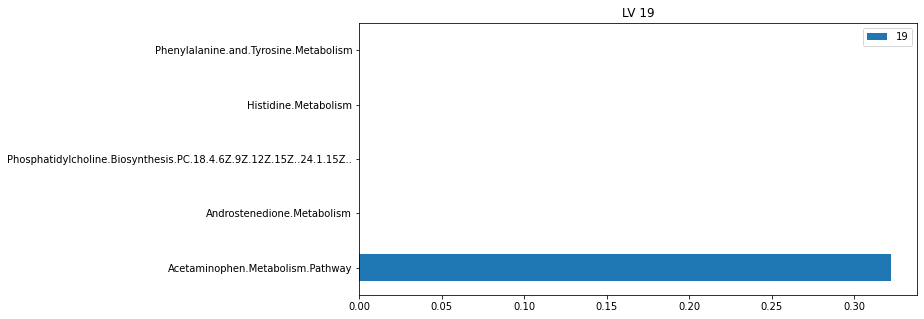

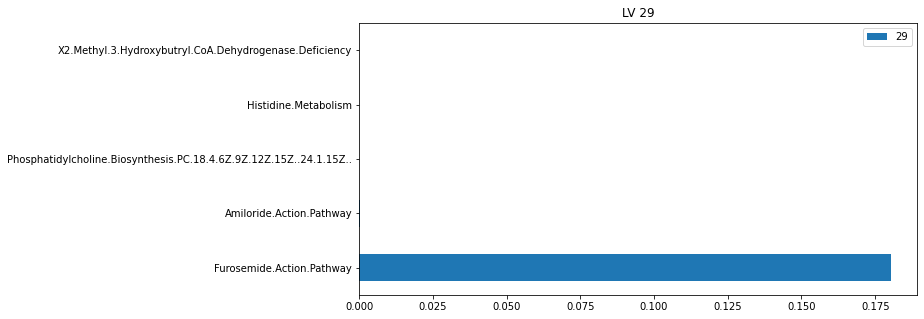

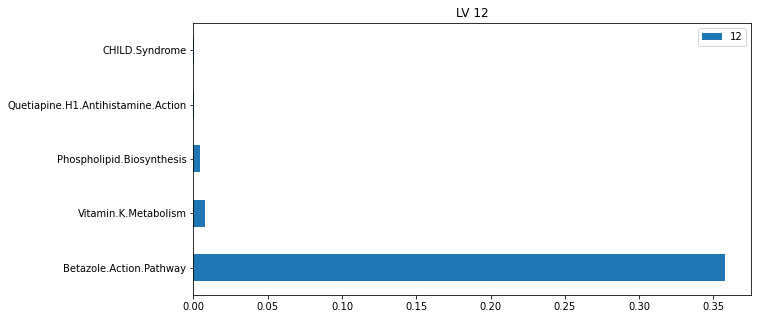

In [310]:
classify(model, Xtrain, Cmat, clinred, clinadj=False)